In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df=pd.read_csv('df3.csv')

In [20]:
df.head()

,date_visite_diagnostiqueur,estimation_ges,annee_construction,shon,surface_habitable,code_insee_commune,geo_score,tv016_departement_code,longitude,latitude,year,month,day,asset_cre,time
0,2011-01-19,3.00,NaN,101.00,111.10,26004.0,NaN,26.0,NaN,NaN,2011.0,1.0,19.0,"Bâtiment à usage principale de bureau, d'admin...",0.0
1,2011-01-26,5.00,1947.0,65.00,71.50,19031.0,0.54,19.0,1.534671,45.154174,2011.0,1.0,26.0,"Bâtiment à usage principale de bureau, d'admin...",7.0
2,2011-01-31,NaN,NaN,78.25,86.08,49007.0,0.75,2.0,-0.595516,47.465137,2011.0,1.0,31.0,"Bâtiment à usage principale de bureau, d'admin...",12.0
3,2011-01-31,1.52,1980.0,NaN,NaN,64054.0,0.33,64.0,-0.286804,43.200653,2011.0,1.0,31.0,Autres,12.0
4,2011-04-04,14.00,1947.0,21.00,23.10,71153.0,0.74,71.0,4.426975,46.793673,2011.0,4.0,4.0,"Bâtiment à usage principale de bureau, d'admin...",75.0


target incoding sur asset_cre, utilisation de la mediane et non de la moyenne pondéré car estimation_ges a une distribution non symétrique.

In [21]:
def weighted_avg(x):
    valid = x.dropna(subset=['estimation_ges', 'surface_habitable'])
    # Exclure les lignes où estimation_ges est nul (0)
    valid = valid[valid['estimation_ges'] != 0]
    
    total_surface = valid['surface_habitable'].sum()
    if total_surface != 0:
        return (valid['estimation_ges'] * valid['surface_habitable']).sum() / total_surface
    return None

In [22]:
target_encoding_mean = df.groupby(['asset_cre']).apply(weighted_avg).reset_index(name='weighted_estimation_ges_year')

C:\Users\tomde\AppData\Local\Temp\ipykernel_10612\3957650154.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  target_encoding_mean = df.groupby(['asset_cre']).apply(weighted_avg).reset_index(name='weighted_estimation_ges_year')


In [23]:
target_encoding_mean

,asset_cre,weighted_estimation_ges_year
0,Autres,21.389318
1,"Autres cas (par exemple: théâtres, salles de s...",25.950627
2,Bâtiment à occupation continue (par exemple: h...,27.578741
3,"Bâtiment à usage principale de bureau, d'admin...",17.677455
4,Centre commercial,16.141312


In [24]:
target_encoding_median = df.groupby(['asset_cre'])['estimation_ges'].median().reset_index()
target_encoding_median.rename(columns={'estimation_ges': 'asset_cre_encoded'}, inplace=True)


In [25]:
target_encoding_median

,asset_cre,asset_cre_encoded
0,Autres,13.00
1,"Autres cas (par exemple: théâtres, salles de s...",15.94
2,Bâtiment à occupation continue (par exemple: h...,10.30
3,"Bâtiment à usage principale de bureau, d'admin...",8.40
4,Centre commercial,7.70


In [26]:
# Fusionner le mapping avec df pour remplacer asset_cre par la médiane correspondante
df = df.merge(target_encoding_median, on='asset_cre', how='left')
df.drop(columns=['asset_cre'], inplace=True)

In [27]:
df.head()

,date_visite_diagnostiqueur,estimation_ges,annee_construction,shon,surface_habitable,code_insee_commune,geo_score,tv016_departement_code,longitude,latitude,year,month,day,time,asset_cre_encoded
0,2011-01-19,3.00,NaN,101.00,111.10,26004.0,NaN,26.0,NaN,NaN,2011.0,1.0,19.0,0.0,8.4
1,2011-01-26,5.00,1947.0,65.00,71.50,19031.0,0.54,19.0,1.534671,45.154174,2011.0,1.0,26.0,7.0,8.4
2,2011-01-31,NaN,NaN,78.25,86.08,49007.0,0.75,2.0,-0.595516,47.465137,2011.0,1.0,31.0,12.0,8.4
3,2011-01-31,1.52,1980.0,NaN,NaN,64054.0,0.33,64.0,-0.286804,43.200653,2011.0,1.0,31.0,12.0,13.0
4,2011-04-04,14.00,1947.0,21.00,23.10,71153.0,0.74,71.0,4.426975,46.793673,2011.0,4.0,4.0,75.0,8.4


Regardons les valeurs manquantes avons d'imputer

In [28]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True).to_frame()

,0
asset_cre_encoded,0.000000
date_visite_diagnostiqueur,0.000013
year,0.000013
month,0.000013
day,0.000013
time,0.000013
tv016_departement_code,0.001264
code_insee_commune,0.004786
geo_score,0.130533
longitude,0.130533


<Axes: >

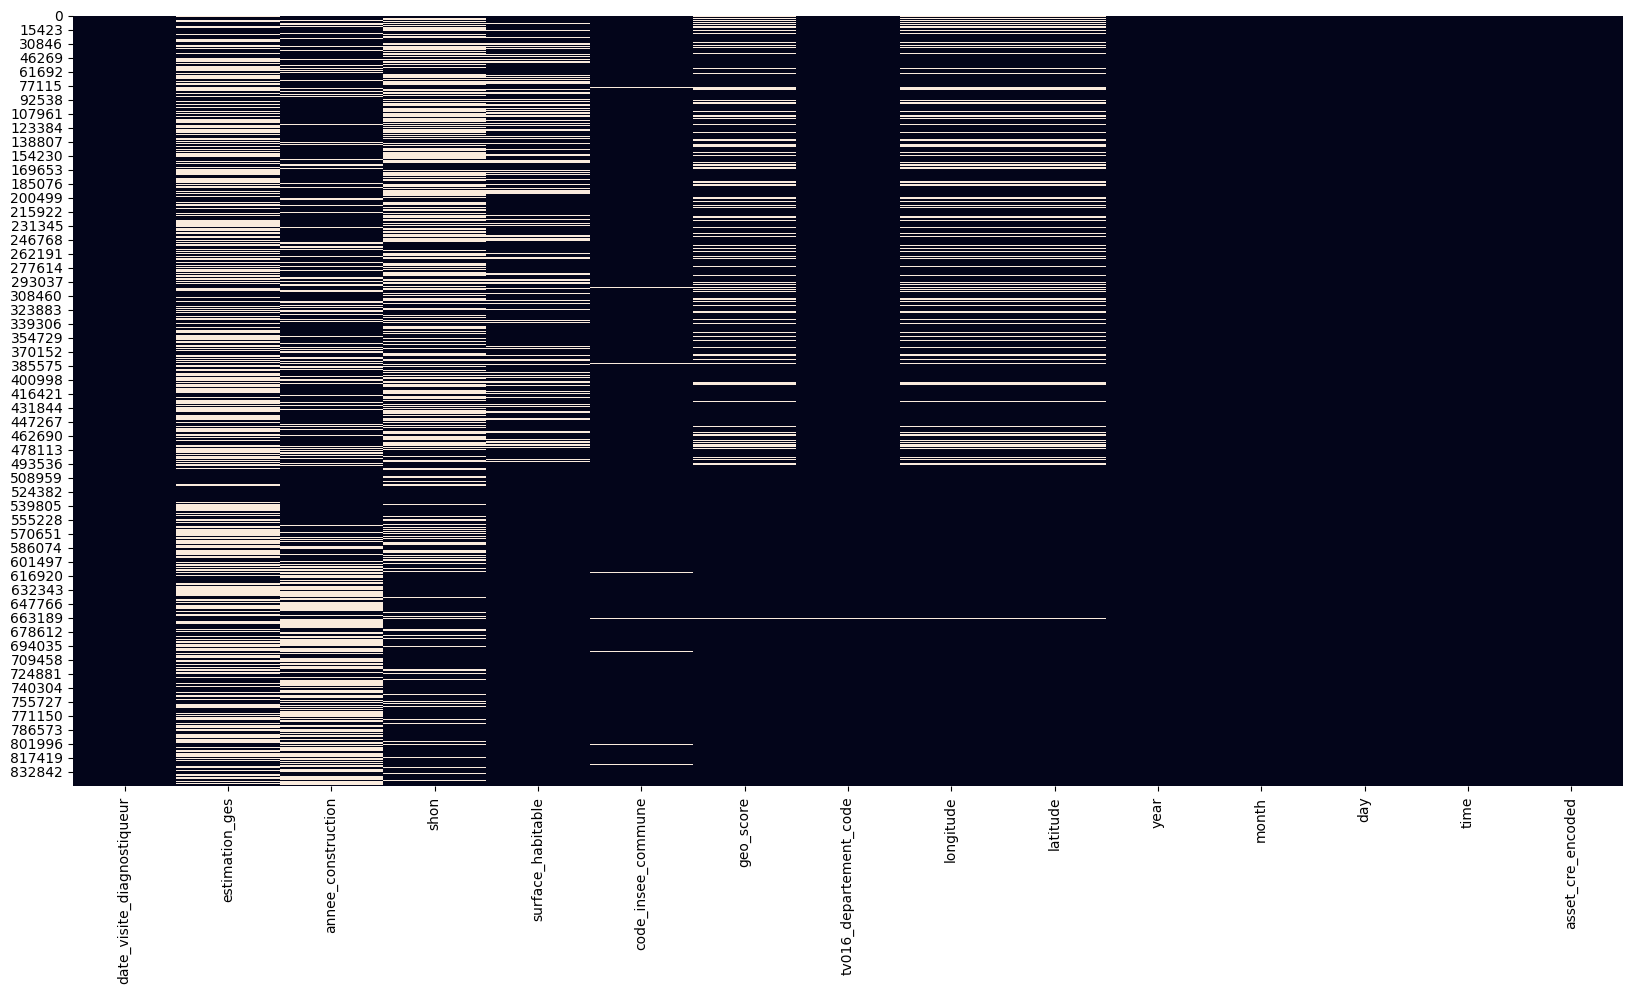

In [29]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)

On est obligé de drop les NaN sur la colonne_annee construction car on ne pourra pas retrouver l'anée en fonction des autres données.

On peut en revanche faire un KNN imputing entre les colonnes code_insee_commune, tv016_departement_code, longitude et latitude.

On peut aussi faire un KNN imputing entre les colonnes shon et surface habitable.

Enfin on peut faire un KNN imputing sur estimation_ges

In [30]:
df.dropna(subset=['annee_construction','date_visite_diagnostiqueur'],inplace=True)
df.dropna()
len(df)

597846

<Axes: >

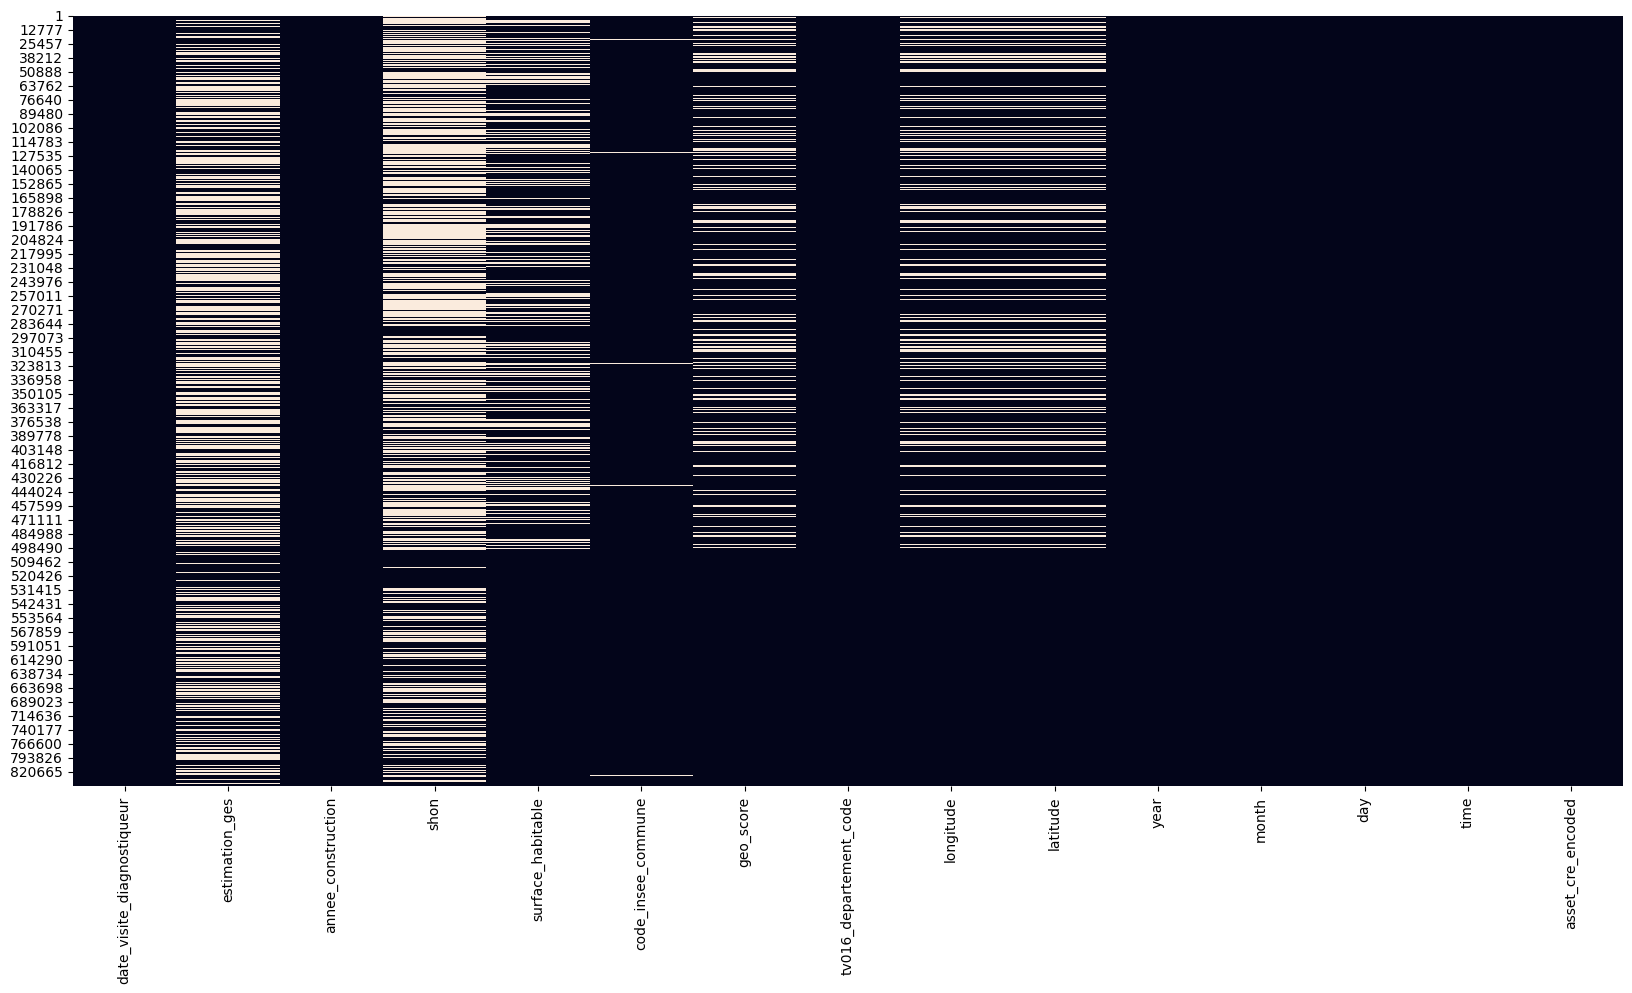

In [31]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)

In [32]:
len(df.dropna())

128321

Heatmap pour voir les colonnes corrélée pour le knn imputing

<Axes: >

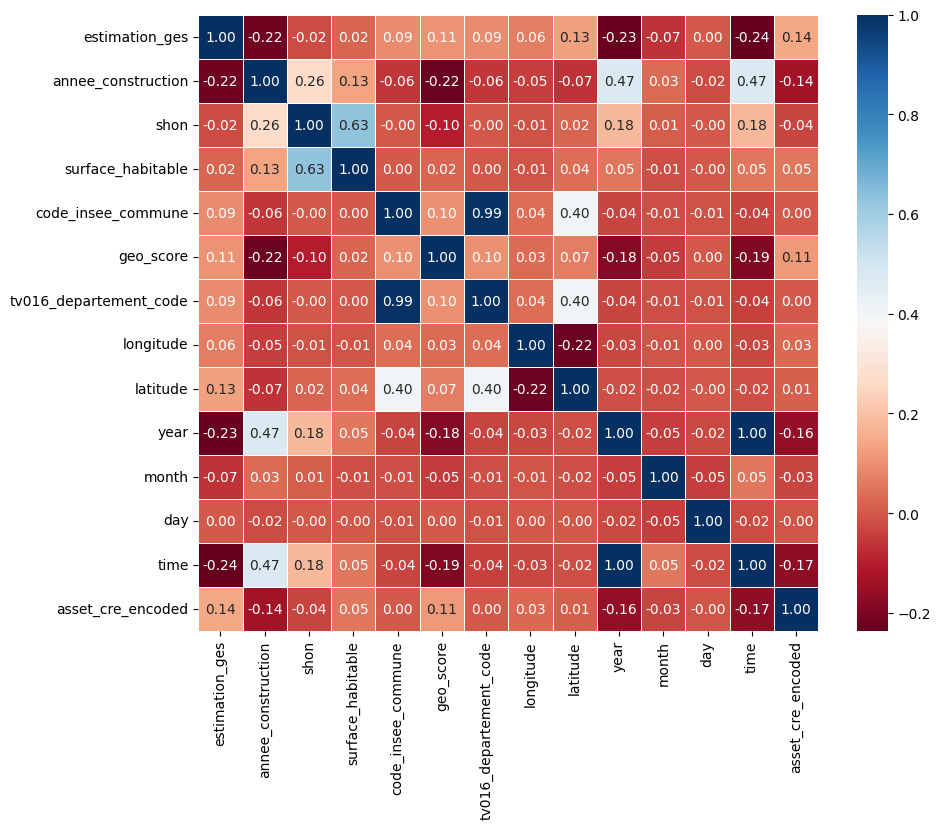

In [33]:
plt.figure(figsize=(10, 8))  # Taille de la figure
sns.heatmap(df.drop(columns=['date_visite_diagnostiqueur']).dropna().corr(), annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)

In [48]:
df.columns

Index(['date_visite_diagnostiqueur', 'estimation_ges', 'annee_construction',
       'shon', 'surface_habitable', 'code_insee_commune', 'geo_score',
       'tv016_departement_code', 'longitude', 'latitude', 'year', 'month',
       'day', 'time', 'asset_cre_encoded'],
      dtype='object')

In [51]:
len(df.dropna(subset=['date_visite_diagnostiqueur', 'surface_habitable', 'code_insee_commune', 'geo_score',
       'tv016_departement_code', 'longitude', 'latitude', 'year', 'month',
       'day', 'time', 'asset_cre_encoded']))

401820